![SE01.png](Figs/SE01.png)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/YitianDai/PowerTech2025-Tutorial.git/master)

### **Tutorial Overview**

**Welcome!** This is the first notebook in a three-part tutorial series on assessing the resilience of energy systems. Across these notebooks, you will learn how to:

1. **Model a Power Network:** Load, inspect, and visualize the synthetic 2000-bus Texas power grid, which will be the subject of our resilience analysis.
2. **Define Hazard Scenarios:** Simulate a natural hazard, specifically a windstorm, and determine its physical impact on the network's infrastructure.
3. **Assess System Resilience:** Quantify the operational impact of the windstorm and evaluate how mitigation measures, like distribution-side flexibility, can enhance resilience.

This first notebook focuses on introducing the Texas 2000-bus network model. More information about the models and some of their applications can also be found in the following links:

- Y. Dai, E. A. Martínez Ceseña, R. Preece, D. Qiu, G. Strbac, B. V. Venkatasubramania, M. Panteli, Y. Zhou, O. Pritchard, J. Mian, B. Ingham, A. Strachan, T. Chikohora, and D. Phillips, “[Whole energy system resilience vulnerability assessment](https://ieeexplore.ieee.org/document/10936044),” in Proceeding of IET Powering Net Zero, 2024

- National Grid Electricity Transmission, “[Whole Energy System Resilience Vulnerability Assessment (WELLNESS)](https://smarter.energynetworks.org/projects/nget-whole-energy-system-resilience-vulnerability-assessment-sifiesrr-rd2_alpha/)”, 2024 

- National Grid Electricity Transmission, “[Forward Resilience Measures](https://smarter.energynetworks.org/projects/nia_ngt0049/) ”, 2021


### **Learning Objectives:** 
By the end of this notebook, you will be able to:
- Load the power network data using the provided Python tools.
- Inspect the key characteristics of the power system, including its size, components, and voltage levels.
- Generate a geographical visualization of the power grid.

### **List of contents**
- [Loading Required Libraries](#1.-Loading-Required-Libraries)
- [The Texas 2000-Bus Test Case](#2.-The-Texas-2000-Bus-Test-Case)
    - [Loading the Network Model](#2.1-Loading-the-Network-Model)
    - [Inspecting Network Characteristics](#2.2-Inspecting-Network-Characteristics)
    - [Geographical Visualization](#2.3-Geographical-Visualization)
- [Analyzing Demand Profiles](#3.-Analyzing-Demand-Profiles)
- [Understanding Power Flow](#4.-Understanding-Power-Flow)
    - [DC Optimal Power Flow](#4.1-DC-Optimal-Power-Flow)
- [Next Steps](#5.-Next-Steps)

### 1. Loading Required Libraries
The notebook will also use the following python packages to facilitate displaying and visualising the assumptions and resilience evaluation

In [7]:
import pandapower as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandapower.plotting as plot
from QRA.engines.Network import NetworkConfig, NetworkClass
from QRA.engines.WindStorm import WindClass, WindConfig  # Load windstorm modelling tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
from collections import Counter

### 2. The Texas 2000-Bus Test Case
Texas has been selected for this study due to its unique grid structure and its high exposure to extreme weather, particularly windstorms and hurricanes. The Texas grid (operated by ERCOT) is largely isolated from the rest of the U.S. transmission system, making it more vulnerable to internal disturbances without external balancing support. Additionally, the Gulf Coast-facing geography makes it a frequent entry point for severe storms, which can pose substantial risks to transmission assets and system stability.

The network used in this study is a 2000-bus synthetic test case representing the geographic footprint of Texas. It was developed to reflect realistic structural, electrical, and spatial characteristics, and is publicly available through the MATPOWER and TAMU synthetic grid repositories:

📚 A.B. Birchfield et al., "[Grid Structural Characteristics as Validation Criteria for Synthetic Networks](https://ieeexplore.ieee.org/document/7725528)," IEEE Transactions on Power Systems, 2017

🌐 [ACTIVSg2000 network dataset](https://electricgrids.engr.tamu.edu/electric-grid-test-cases/activsg2000/)

#### 2.1 Loading the Network Model
To load this test network (provided in Excel format), the following code uses the `NetworkConfig()` class to retrieve the relevant file and load it into memory:

In [8]:
ncon = NetworkConfig()  # Set tool with default configuration
nc = NetworkClass(ncon)
net = nc._get_model()
wcon = WindConfig()  # Assigning wind configuration to a variable
ws = WindClass(wcon)  # Passing the modelling configuration to the tool

print('File name:\n\t', ncon.get_name())  # Display loaded file

File name:
	 case_ACTIVSg2000.xlsx


#### 2.2 Inspecting Network Characteristics
The synthetic Texas test system is loaded using the `NetworkClass()` wrapper, which reads from the configuration defined by `NetworkConfig()`. Once loaded, the network object contains all elements required for power system simulation — including buses, generators, loads, branches, and their respective parameters.


In [9]:
print("=== Network Summary ===")
print(f"🧩 Buses: {len(net.bus)} \n🔌 Lines: {len(net.line)}\n🔄 Transformers: {len(net.trafo)}\n⚡ Generators: {len(net.gen)}\n📥 Loads: {len(net.load)}")

gen_cap = net.gen.get("max_p_mw", net.gen["p_mw"]).sum()
print(f"🔋 Total Gen Capacity: {gen_cap:.1f} MW\n🏙️ Total Load: {net.load['p_mw'].sum():.1f} MW")

slack = set(net.ext_grid["bus"]) if "ext_grid" in net else set()
pv = set(net.gen["bus"])
all_buses = set(net.bus.index)
print(f"🎯 Slack Buses: {len(slack)}\n📡 PV Buses: {len(pv)}\n📦 PQ Buses: {len(all_buses - slack - pv)}")

if "vn_kv" in net.bus:
    print("\n🔌 Voltage Levels:")
    for kv, count in Counter(net.bus["vn_kv"].round()).items():
        print(f"  - {int(kv)} kV: {count} buses")

=== Network Summary ===
🧩 Buses: 2000 
🔌 Lines: 2359
🔄 Transformers: 847
⚡ Generators: 484
📥 Loads: 1125
🔋 Total Gen Capacity: 86532.4 MW
🏙️ Total Load: 67109.2 MW
🎯 Slack Buses: 1
📡 PV Buses: 484
📦 PQ Buses: 1515

🔌 Voltage Levels:
  - 115 kV: 826 buses
  - 230 kV: 152 buses
  - 14 kV: 278 buses
  - 22 kV: 14 buses
  - 18 kV: 96 buses
  - 500 kV: 120 buses
  - 161 kV: 453 buses
  - 20 kV: 20 buses
  - 24 kV: 20 buses
  - 13 kV: 21 buses


#### 2.3 Geographical Visualization
To better understand the spatial layout of the network, we can create a geographical plot. The following visualization overlays the bus locations and transmission lines on a map of Texas, providing a clear picture of the grid's footprint. 

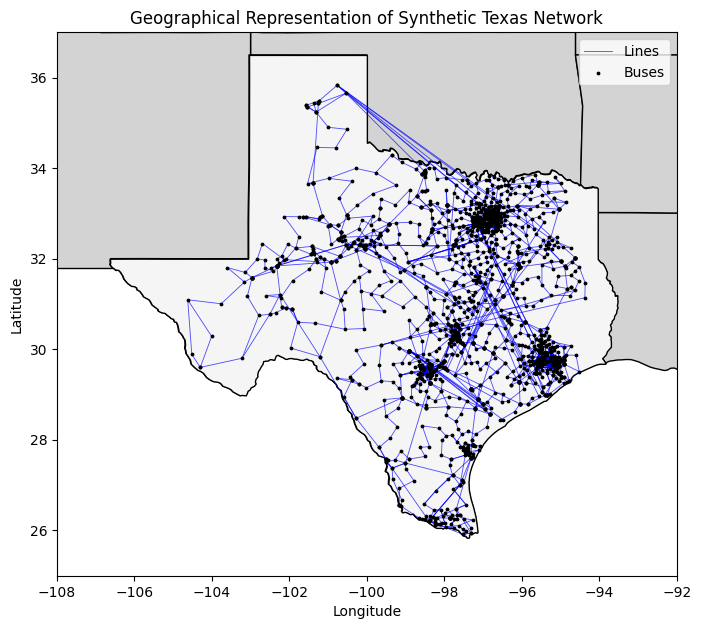

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ws.plot_base(ax, net)
ax.set(xlim=(-108, -92), ylim=(25, 37), xlabel="Longitude", ylabel="Latitude", title="Geographical Representation of Synthetic Texas Network")
ax.legend()
plt.show()

### 3. Analyzing Demand Profiles
This model incorporates time-varying load profiles based on historical records. The figure below illustrates the hourly evolution of both **active (P)** and **reactive (Q)** power demands across all load buses over an entire year (8760 hours).

Each line in the figures below represents the load pattern of an individual bus, highlighting the diversity of demand behaviours and seasonal fluctuations observed in the network.

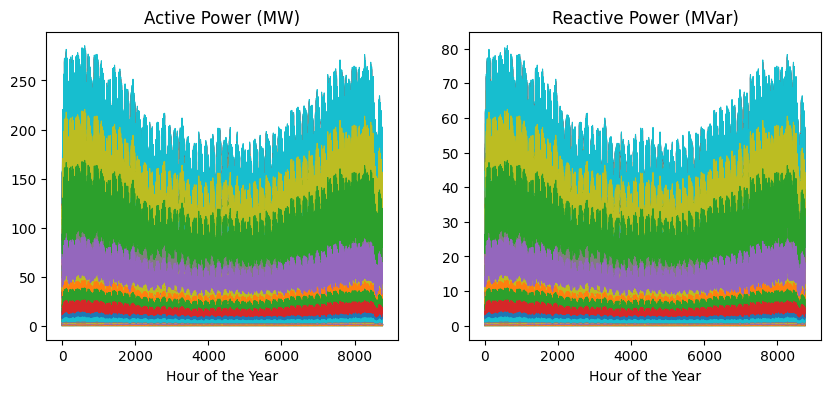

In [11]:
# Load hourly active (P) and reactive (Q) load data
p, q = nc._get_load_hrly()
x = np.arange(p.shape[1])  # 8760 hours in a year

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Loop over both P and Q data, and corresponding axes and titles
for ax, data, title in zip((ax1, ax2), (p, q), ("Active Power (MW)", "Reactive Power (MVar)")):
    ax.plot(x, data.T, linewidth=0.8)  # Plot all load profiles (rows) as lines
    ax.set(title=title, xlabel="Hour of the Year", aspect='auto')
plt.show()

### 4. Understanding Power Flow
Power flow (or load flow) analysis is a fundamental tool in power system operation. It determines how electricity is transmitted from generators to loads through the network under steady-state conditions. It calculates key variables like bus voltages, power flows on lines, and system losses.

Two common types of power flow calculations:
- AC Power Flow: Full nonlinear equations accounting for both active (P) and reactive (Q) power, voltage magnitudes, and angles. More accurate but computationally heavier.
- DC Power Flow: Linearised approximation of AC power flow. It assumes:
    - Flat voltage profile (|V| ≈ 1.0 p.u.)
    - Negligible line resistance
    - Small angle differences

#### 4.1 DC Optimal Power Flow
For this analysis, we will use a **DC Optimal Power Flow (DCOPF)**. This is a linearized approximation of the full AC power flow that focuses on active power (P) and voltage angles. It is widely used for high-level analysis because it is computationally efficient while still providing a good estimate of line loading

The heatmap below shows the percentage loading of each transmission line after running the DCOPF. This gives us a baseline understanding of which parts of the grid are most heavily used under normal conditions

✅ DCOPF converged


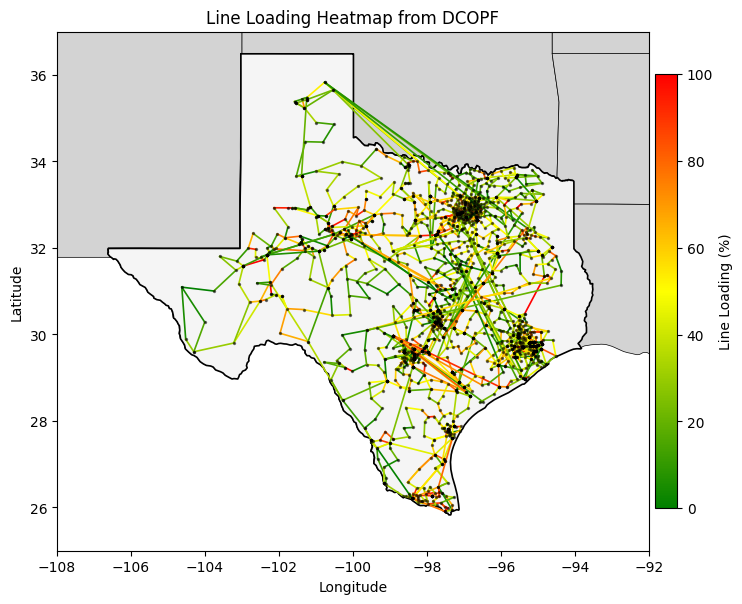

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Run DCOPF ---
pp.rundcopp(net, numba=False)
print("✅ DCOPF converged" if net.OPF_converged else "❌ DCOPF did not converge")

# === Prepare bus and line data ===
bus_coords = net.bus_geodata.copy().set_index(net.bus.index)
line_data = net.line[["from_bus", "to_bus"]]
line_loading = net.res_line.loading_percent

# === Load and filter Texas shapefile ===
states = gpd.read_file(os.path.join(os.getcwd(), "Inputs/cb_2020_us_state_20m/cb_2020_us_state_20m.shp")).to_crs(epsg=4326)
texas = states[states["STUSPS"] == "TX"]
nearby = states.cx[-110:-90, 25:40]

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 8))
nearby.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5)
texas.plot(ax=ax, facecolor="whitesmoke", edgecolor="black", linewidth=1.2)

# === Create custom green → yellow → red colormap ===
cmap = colors.LinearSegmentedColormap.from_list("loadmap", ["green", "yellow", "red"])
norm = colors.Normalize(vmin=min(line_loading), vmax=max(line_loading))

# === Draw lines with color based on loading percent ===
for i, row in line_data.iterrows():
    f, t = row["from_bus"], row["to_bus"]
    if f in bus_coords.index and t in bus_coords.index:
        x0, y0 = bus_coords.loc[f, ["x", "y"]]
        x1, y1 = bus_coords.loc[t, ["x", "y"]]
        ax.plot([x0, x1], [y0, y1], color=cmap(norm(line_loading.at[i])), linewidth=1.2, zorder=2)
ax.scatter(bus_coords["x"], bus_coords["y"], color='black', alpha=0.5, s=2, zorder=3)

cm.ScalarMappable(norm=norm, cmap=cmap).set_array([])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.035, pad=0.01, label="Line Loading (%)")
ax.set(xlim=(-108, -92), ylim=(25, 37), xlabel="Longitude", ylabel="Latitude", title="Line Loading Heatmap from DCOPF")
plt.show()

### 5. Next Steps
You have now successfully:
- Loaded, inspected, and visualised the 2000-bus synthetic Texas power network,
- Analysed its baseline operational structure and key characteristics.

This model serves as the foundation for subsequent resilience assessments.

In the next notebook, [SE02_Hazard_Scenarios.ipynb](SE02_Hazard_Scenarios.ipynb), a series of windstorm scenarios will be defined and overlaid onto this network to:
- Simulate its path and severity,  
- Identify physically exposed components,  
- Prepare for failure simulation and risk propagation analysis.